In [1]:
#! pip install pydub
#! pip install noisereduce

In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.lite as tflite
from tensorflow.keras import layers
from tensorflow.keras import models

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display

#Import for the dataset
#import opendatasets as od

import os
#import tensorflow_model_optimization as tfmot

from pydub import AudioSegment
import noisereduce as nr


import librosa
from scipy.io import wavfile
import soundfile as sf
import wave

import wave
import contextlib

from librosa import load
from librosa.util import fix_length

#import argparse

/opt/anaconda3/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
#od.download("https://www.kaggle.com/fabianavinci/guitar-chords-dataset-v1")


In [4]:
############################## Parameters ##############################
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

freq=44100
batch_size=64
epochs=50

In [5]:
############################## Dataset ##############################
dataset_version=3

# No noise reduc everything at 44100
data_dir = 'guitar-chords-v3_44100'


'''
#!!!!!! When we have the right datase we change it to the code at the end
zip_path = tf.keras.utils.get_file(
        origin="https://www.kaggle.com/fabianavinci/guitar-chords-v3",
        fname='guitar-chords-v3.zip',
        extract=True,
        cache_dir='.', cache_subdir='data')
'''


############################ Labels for the dataset ############################
chords = np.array(tf.io.gfile.listdir(str(data_dir+ '/Training/')))
chords = chords[chords != 'README.md']
print('Chords:', chords)


Chords: ['Am' 'Bb' 'Em' 'G' 'F' 'Dm' 'C' 'Bdim']


In [6]:
########################### MAX DURATION OF AUDIOS  ############################
'''max_duration=0 
set_type= "Training"
for i in chords:
    directory=str(f'{data_dir}/{set_type}/{i}/')
    for file in os.listdir(directory):               
        audio, sampling_rate = librosa.load(f'{directory}/{file}', sr=freq, mono=True)
        duration=librosa.get_duration(y=audio, sr=freq)
        if duration> max_duration:
            max_duration= duration
        
print(f"Audio duration: {max_duration}")
'''

'max_duration=0 \nset_type= "Training"\nfor i in chords:\n    directory=str(f\'{data_dir}/{set_type}/{i}/\')\n    for file in os.listdir(directory):               \n        audio, sampling_rate = librosa.load(f\'{directory}/{file}\', sr=freq, mono=True)\n        duration=librosa.get_duration(y=audio, sr=freq)\n        if duration> max_duration:\n            max_duration= duration\n        \nprint(f"Audio duration: {max_duration}")\n'

In [7]:
def transform_origianl_samples(chords, set_type, freq, dataset_version, data_dir):
    required_audio_size = 8
    print(f'Required audio size: {required_audio_size}' )

    max_shape=0
    print(f'Data set version: {dataset_version}')
    for i in chords:
    # Directory: Original dataset without transformations 
        directory=str(f'{data_dir}/{set_type}/{i}/')
        
        for file in os.listdir(directory):  

            audio, sampling_rate = librosa.load(f'{directory}/{file}', sr=freq, mono=True)
            # perform noise reduction
            #reduced_noise = nr.reduce_noise(y=audio, sr=sampling_rate)
            #print(type(reduced_noise))
            #print("Audio tipo", audio.shape)
            shape_audio=audio.shape
            #padded_audio = fix_length(audio, size=8*sf) # array size is required_audio_size*sampling frequency

            if shape_audio[0]> max_shape:
                max_shape= shape_audio[0]

            sf.write(directory+ f"{file}",  audio, sampling_rate)
    print(f"Audio transformations: Frequency - {freq}     Folder -  {set_type}    Path -{directory}  ")
    print(f"MAX AUDIO SHAPE = {max_shape}  ")
    
    return max_shape





In [8]:
print(freq)
print(data_dir)


44100
guitar-chords-v3_44100


In [9]:
set_type="Training"
max_shape = transform_origianl_samples(chords, set_type, freq, dataset_version, data_dir )
set_type="Test"
transform_origianl_samples(chords, set_type, freq, dataset_version, data_dir )


Required audio size: 8
Data set version: 3
Audio transformations: Frequency - 44100     Folder -  Training    Path -guitar-chords-v3_44100/Training/Bdim/  
MAX AUDIO SHAPE = 720765  
Required audio size: 8
Data set version: 3
Audio transformations: Frequency - 44100     Folder -  Test    Path -guitar-chords-v3_44100/Test/Bdim/  
MAX AUDIO SHAPE = 340293  


340293

In [10]:
############################ Dataset split ############################
def split_dataset(set_type, chords, data_dir):

    filenames=  tf.io.gfile.glob(str(data_dir) + f'/{set_type}/*/*')

    if set_type=="Training":
        filenames=tf.random.shuffle(filenames)

    filenames_samples=len(filenames)
    print(f"########################## {set_type} information ##############################")
    print(f'{set_type} - Number of total examples:', filenames_samples)
    print(f'{set_type} - Number of examples per label:',
        len(tf.io.gfile.listdir(str(data_dir+ f'/{set_type}/'+ chords[0]))))
    print(f'{set_type} - Example file tensor:', filenames[1])
    
    return filenames,filenames_samples

In [11]:
############################ Training ############################
set_type="Training"
training_filenames,train_num_samples = split_dataset(set_type, chords, data_dir )

############################ Test ############################
set_type="Test"
test_filenames, _ = split_dataset(set_type, chords, data_dir )

########################## Training information ##############################
Training - Number of total examples: 1440
Training - Number of examples per label: 180
Training - Example file tensor: tf.Tensor(b'guitar-chords-v3_44100/Training/Am/Am_Electric_Fabi_1.wav', shape=(), dtype=string)
########################## Test information ##############################
Test - Number of total examples: 320
Test - Number of examples per label: 40
Test - Example file tensor: guitar-chords-v3_44100/Test/Am/Am_AcusticVince_JO_2.wav


In [12]:
############################ Validation set ############################
val_filenames = training_filenames[int(train_num_samples*0.9):]
len_val=len(val_filenames)
print("########################## Validation information ##############################")
print('Validation - Number of total examples:',len_val )

########################## Validation information ##############################
Validation - Number of total examples: 144


In [13]:
class SignalGenerator:
    def __init__(self, labels, sampling_rate, frame_length, frame_step, max_shape, batch_size,
            num_mel_bins=None, lower_frequency=None, upper_frequency=None,
            num_coefficients=None, mfcc=False,plot=False):
        self.labels = labels
        self.sampling_rate = sampling_rate
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.num_mel_bins = num_mel_bins
        self.lower_frequency = lower_frequency
        self.upper_frequency = upper_frequency
        self.num_coefficients = num_coefficients
        num_spectrogram_bins = (frame_length) // 2 + 1
        self.plot=plot
        self.max_shape=max_shape
        self.batch_size=batch_size

        if mfcc is True:
            self.linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
                    self.num_mel_bins, num_spectrogram_bins, self.sampling_rate,
                    self.lower_frequency, self.upper_frequency)
            self.preprocess = self.preprocess_with_mfcc
        else:
            self.preprocess = self.preprocess_with_stft

    def read(self, file_path):
        parts = tf.strings.split(file_path, os.path.sep)
        label = parts[-2]
        label_id = tf.argmax(label == self.labels)
        audio_binary = tf.io.read_file(file_path)
        audio, _ = tf.audio.decode_wav(audio_binary)
        audio = tf.squeeze(audio, axis=1)
        
        return audio, label_id

       
    def pad(self, audio):
        #print(self.sampling_rate)
        input_len = max_shape
        audio = audio[:input_len]
        zero_padding = tf.zeros( self.max_shape - tf.shape(audio), dtype=tf.float32)
        audio = tf.concat([audio, zero_padding], 0)
        audio.set_shape([max_shape])

        return audio

    def get_spectrogram(self, audio):
        stft = tf.signal.stft(audio, frame_length=self.frame_length,
                frame_step=self.frame_step, fft_length=self.frame_length)
        spectrogram = tf.abs(stft)

        return spectrogram

    def get_mfccs(self, spectrogram):
        mel_spectrogram = tf.tensordot(spectrogram,
                self.linear_to_mel_weight_matrix, 1)
        log_mel_spectrogram = tf.math.log(mel_spectrogram + 1.e-6)
        mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)
        mfccs = mfccs[..., :self.num_coefficients]

        return mfccs

    def preprocess_with_stft(self, file_path, plot):
        audio, label = self.read(file_path)
        audio = self.pad(audio)
        spectrogram = self.get_spectrogram(audio)
        spectrogram = tf.expand_dims(spectrogram, -1)
        
        if plot == False:
            spectrogram = tf.image.resize(spectrogram, [32, 32])

        return spectrogram, label

    def preprocess_with_mfcc(self, file_path):
        audio, label = self.read(file_path)
        audio = self.pad(audio)
        spectrogram = self.get_spectrogram(audio)
        mfccs = self.get_mfccs(spectrogram)
        mfccs = tf.expand_dims(mfccs, -1)

        return mfccs, label

    def make_dataset(self, files, train,batch_size):
        ds = tf.data.Dataset.from_tensor_slices(files)
        ds = ds.map(self.preprocess, num_parallel_calls=4)
        ds = ds.batch(batch_size)
        ds = ds.cache()
        if train is True:
            ds = ds.shuffle(100, reshuffle_each_iteration=True)

        return ds
    
    def read_waveform(self, file_path ):
        parts = tf.strings.split(file_path, os.path.sep)
        label = parts[-2]
        label_id = tf.argmax(label == self.labels)
        audio_binary = tf.io.read_file(file_path)
        audio, _ = tf.audio.decode_wav(audio_binary)
        #audio = tf.squeeze(audio, axis=1)
        
        return audio, label
    
    #Function to get the spectogram
    def get_spectrogram_waveform(self, waveform):
        # Zero-padding for an audio waveform with less than 16,000 samples.
        ############# TRY a different input len ############################
        #input_len = freq
        #waveform = waveform[:input_len]
        zero_padding = tf.zeros(
                      [self.sampling_rate] - tf.shape(waveform), dtype=tf.float32)
        # Cast the waveform tensors' dtype to float32.
        waveform = tf.cast(waveform, dtype=tf.float32)
        # Concatenate the waveform with `zero_padding`, which ensures all audio
        # clips are of the same length.
        equal_length = tf.concat([waveform, zero_padding], 0)
        waveform=waveform.set_shape([self.sampling_rate])
        
        # Convert the waveform to a spectrogram via a STFT.
        spectrogram = tf.signal.stft(
          equal_length, self.frame_length, self.frame_step)
        # Obtain the magnitude of the STFT.
        spectrogram = tf.abs(spectrogram)

        # Add a `channels` dimension, so that the spectrogram can be used
        # as image-like input data with convolution layers (which expect
        # shape (`batch_size`, `height`, `width`, `channels`).
        #spectrogram = spectrogram[..., tf.newaxis]
        return spectrogram 

    

In [14]:
STFT_OPTIONS = {'frame_length': 256, 'frame_step': 128, 'mfcc': False , 'max_shape': max_shape }
MFCC_OPTIONS = {'frame_length': 640, 'frame_step': 320, 'mfcc': True,
        'lower_frequency': 20, 'upper_frequency': 4000, 'num_mel_bins': 40,
        'num_coefficients': 10, 'max_shape': max_shape }
mfcc=True

if mfcc is True:
    options = MFCC_OPTIONS
    strides = [2, 1]
else:
    options = STFT_OPTIONS
    strides = [2, 2]
    
    
generator = SignalGenerator(chords, freq,batch_size=batch_size, **options)
train_ds = generator.make_dataset(training_filenames, True,batch_size=batch_size)
val_ds = generator.make_dataset(val_filenames, False ,batch_size=batch_size)
test_ds = generator.make_dataset(test_filenames, False,batch_size=batch_size)





Parts:Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
Tfshape Tensor("Shape:0", shape=(1,), dtype=int32)
Parts:Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
Tfshape Tensor("Shape:0", shape=(1,), dtype=int32)
Parts:Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
Tfshape Tensor("Shape:0", shape=(1,), dtype=int32)


In [15]:
#For a better performance and OPTIMIZATION
AUTOTUNE = tf.data.experimental.AUTOTUNE #Optimize the number of parellel calls

train_files_ds = tf.data.Dataset.from_tensor_slices(training_filenames)
train_waveform_ds = train_files_ds.map(
    map_func=generator.read_waveform,
    num_parallel_calls=AUTOTUNE)



Parts:Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)


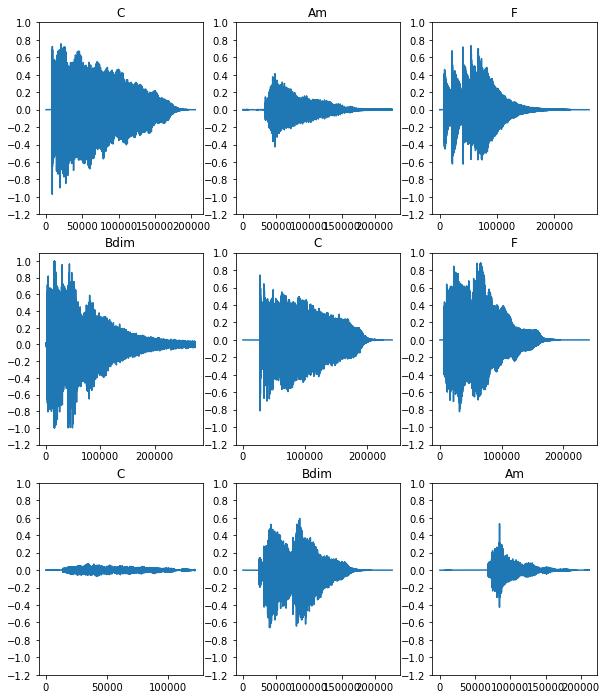

In [16]:
############################ Data exploration ############################

rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(train_waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

In [17]:
#Visualization of the spectogram
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]


    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

In [18]:
#STFT
for waveform, label in train_waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram,_ = generator.preprocess_with_stft(training_filenames[0],plot=True)


True
Parts:[b'guitar-chords-v3_44100' b'Training' b'C' b'C_AcusticPlug17_1.wav']
Tfshape [205653]


In [19]:
print(training_filenames[0].numpy())
spectrogram,_ = generator.preprocess_with_stft(training_filenames[0],plot=True)


b'guitar-chords-v3_44100/Training/C/C_AcusticPlug17_1.wav'
True
Parts:[b'guitar-chords-v3_44100' b'Training' b'C' b'C_AcusticPlug17_1.wav']
Tfshape [205653]


<ipython-input-17-e63ec2110b1b>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


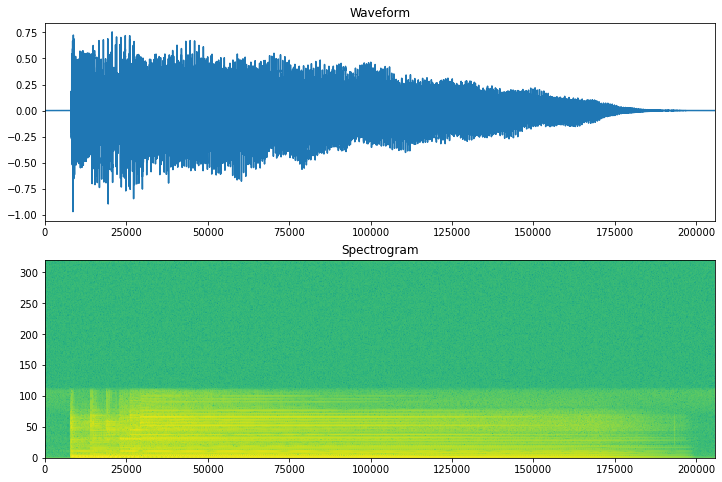

In [20]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, len(waveform)  ])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
axes[1].set_xlim([0,len(waveform)])
plt.show()

In [21]:
############################ Parameters for the Model ############################

shape,_ = generator.preprocess_with_mfcc(training_filenames[0])
output_shape = len(chords)
input_shape = shape.shape
print('input shape',input_shape)



Parts:[b'guitar-chords-v3_44100' b'Training' b'C' b'C_AcusticPlug17_1.wav']
Tfshape [205653]
input shape (2251, 10, 1)


In [22]:
############################ MODEL ############################
cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(input_shape=input_shape, filters=128, kernel_size=[3,3], strides=strides, use_bias=False),
    tf.keras.layers.BatchNormalization(momentum=0.1),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(input_shape=input_shape, filters=128, kernel_size=[3,3], strides=[1,1], use_bias=False),
    tf.keras.layers.BatchNormalization(momentum=0.1),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(input_shape=input_shape, filters=128, kernel_size=[3,3], strides=[1,1], use_bias=False),
    tf.keras.layers.BatchNormalization(momentum=0.1),
    tf.keras.layers.ReLU(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units = 8)
])

dcnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(input_shape=input_shape, filters=256, kernel_size=[3,3], strides=strides, use_bias=False),
    tf.keras.layers.BatchNormalization(momentum=0.1),
    tf.keras.layers.ReLU(),
    tf.keras.layers.DepthwiseConv2D(kernel_size=[3, 3], strides=[1, 1], use_bias=False),
    tf.keras.layers.Conv2D(filters=128, kernel_size=[1,1], strides=[1,1], use_bias=False),
    tf.keras.layers.BatchNormalization(momentum=0.1),
    tf.keras.layers.ReLU(),
    tf.keras.layers.DepthwiseConv2D(kernel_size=[3, 3], strides=[1, 1], use_bias=False),
    tf.keras.layers.Conv2D(filters=64, kernel_size=[1,1], strides=[1,1], use_bias=False),
    tf.keras.layers.BatchNormalization(momentum=0.1),
    tf.keras.layers.ReLU(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units = 8)
])

In [24]:
model=cnn
def compile_and_train(model, train_ds, val_ds,epochs):
    # then we can compile and print the summary of the model
    optimizer = tf.keras.optimizers.Adam()
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    summary = model.summary()
    print(f"Start training {model.name} model")
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,batch_size=batch_size)

    return model, summary, history

trained_model, summary,history= compile_and_train(model,train_ds,val_ds,epochs)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1125, 8, 128)      1152      
_________________________________________________________________
batch_normalization (BatchNo (None, 1125, 8, 128)      512       
_________________________________________________________________
re_lu (ReLU)                 (None, 1125, 8, 128)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1123, 6, 128)      147456    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1123, 6, 128)      512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 1123, 6, 128)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1121, 4, 128)      1

23/23 [==============================] - 180s 8s/step - loss: 0.3112 - sparse_categorical_accuracy: 0.9243 - val_loss: 0.3097 - val_sparse_categorical_accuracy: 0.9444
Epoch 37/50
23/23 [==============================] - 182s 8s/step - loss: 0.3143 - sparse_categorical_accuracy: 0.9201 - val_loss: 0.3331 - val_sparse_categorical_accuracy: 0.9514
Epoch 38/50
23/23 [==============================] - 178s 8s/step - loss: 0.2962 - sparse_categorical_accuracy: 0.9312 - val_loss: 0.2972 - val_sparse_categorical_accuracy: 0.9236
Epoch 39/50
23/23 [==============================] - 182s 8s/step - loss: 0.2994 - sparse_categorical_accuracy: 0.9264 - val_loss: 0.2972 - val_sparse_categorical_accuracy: 0.9583
Epoch 40/50
23/23 [==============================] - 178s 8s/step - loss: 0.2849 - sparse_categorical_accuracy: 0.9396 - val_loss: 0.3119 - val_sparse_categorical_accuracy: 0.9306
Epoch 41/50
23/23 [==============================] - 176s 8s/step - loss: 0.2787 - sparse_categorical_accuracy: 

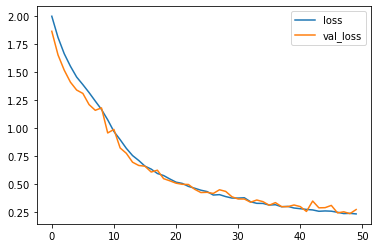

In [27]:
#PLOT loss metric to evaluate
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

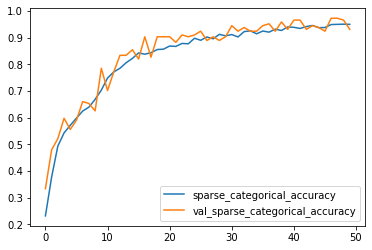

In [28]:
metrics = history.history
plt.plot(history.epoch, metrics['sparse_categorical_accuracy'], metrics['val_sparse_categorical_accuracy'])
plt.legend(['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'])
plt.show()

In [29]:
###Model trained evaluation
error_test, accuracy_test = trained_model.evaluate(test_ds)
print(f'Test error {error_test}' )
print(f'Test accuracy = {accuracy_test*100}%' )

5/5 [==============================] - 73s 15s/step - loss: 0.6968 - sparse_categorical_accuracy: 0.8062
Test error 0.6968396902084351
Test accuracy = 80.62499761581421%


In [ ]:
####################### CONFUSION MATRIX ##########################
test_audio = []
test_labels = []

for audio, label in test_ds:
    #test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_ds), axis=1)
y_true = test_labels

y_true=y_true.reshape(320,)

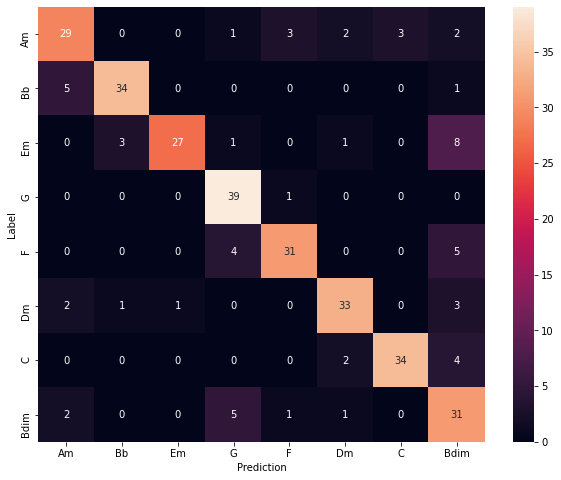

In [32]:
#Transformation to tensor - 1D 

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=chords,
            yticklabels=chords,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [33]:
import tensorflow.lite as tflite

path='project_try/'
converter = tflite.TFLiteConverter.from_keras_model(trained_model)
tflite_model = converter.convert()

with open(f'cnn_{freq}_{batch_size}_{accuracy_test}_{dataset_version}.tflite', 'wb') as f:
    f.write(tflite_model)

convert = tflite.TFLiteConverter.from_keras_model(trained_model)
converter.optimizations = [tflite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

path_save = f'cnn_{freq}_{batch_size}_{accuracy_test}_{dataset_version}_quantized.tflite'

with open(path_save, 'wb') as f:
    f.write(quantized_tflite_model)


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /var/folders/8v/dtwd43m578z77xmn8rnjzs0r0000gn/T/tmp8jr6rg8p/assets
INFO:tensorflow:Assets written to: /var/folders/8v/dtwd43m578z77xmn8rnjzs0r0000gn/T/tmprfx0zwx_/assets


INFO:tensorflow:Assets written to: /var/folders/8v/dtwd43m578z77xmn8rnjzs0r0000gn/T/tmprfx0zwx_/assets


'\nmodel=tf.keras.models.load_model(""/content/best_model_11class.hdf5"")\nconverter = tf.lite.TFLiteConverter.from_keras_model(model)\nconverter.experimental_new_converter = True\ntflite_model = converter.convert()\nopen("converted_model.tflite", "wb").write(tflite_model) '

In [34]:
#Just a check of the model accuracy

def accuracy(pred, true):
    return sum(1 for x,y in zip(true,pred) if x == y) / float(len(true))
def evaluate_TF_LITE(path, test_ds):
    interpreter = tflite.Interpreter(model_path=path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    outputs = []
    labels = []

    dataset = test_ds.unbatch().batch(1)
    for data in dataset:
        my_input = np.array(data[0], dtype=np.float32)
        label = np.array(data[1], dtype=np.int32)
        labels.append(label[0])
        interpreter.set_tensor(input_details[0]["index"], my_input)
        interpreter.invoke()
        my_output = interpreter.get_tensor(output_details[0]["index"])
        my_output = np.argmax(np.squeeze(np.array(my_output)))
        outputs.append(my_output)

    comput_accuracy = accuracy(outputs, labels)

    return comput_accuracy


In [35]:
accuracy_TFLite= evaluate_TF_LITE(f'cnn_{freq}_{batch_size}_{accuracy_test}_{dataset_version}.tflite', test_ds)

In [36]:
accuracy_TFLite

0.80625